# RNN Model - Training Notebook

## Import

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    precision_score, recall_score, f1_score
)
from tensorflow.keras.callbacks import EarlyStopping
import joblib

## Seeds

In [3]:
# Set random seeds for reproducibility
random.seed(21)
np.random.seed(21)
tf.random.set_seed(21)

## Load Data

In [4]:
# Load your DataFrame
df = pd.read_csv('parsed_data_final.csv', index_col=0)

In [5]:
print(df.head())

           Gene ID    Transcript ID  Position Nucleotide 1 Nucleotide 2  \
0  ENSG00000004059  ENST00000000233       244        AAGAC        AGACC   
1  ENSG00000004059  ENST00000000233       261        CAAAC        AAACT   
2  ENSG00000004059  ENST00000000233       316        GAAAC        AAACA   
3  ENSG00000004059  ENST00000000233       332        AGAAC        GAACA   
4  ENSG00000004059  ENST00000000233       368        AGGAC        GGACA   

  Nucleotide 3  N1 Length Avg  N1 Length Median  N1 Length Min  N1 Length Max  \
0        GACCA       0.008264           0.00697        0.00199         0.0339   
1        AACTG       0.006609           0.00564        0.00199         0.0222   
2        AACAG       0.007570           0.00631        0.00232         0.0299   
3        AACAT       0.010620           0.00902        0.00232         0.0370   
4        GACAA       0.010701           0.00896        0.00199         0.0478   

   ...  N3 Length Max  N3 SD Avg  N3 SD Median  N3 SD Min  N3 

## Prepare Data
Preparing both sequence data and numerical signal data as inputs.

In [6]:
# Ensure 'Gene ID' is treated as a string
df['Gene ID'] = df['Gene ID'].astype(str)

# Map nucleotides to integers
nucleotide_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'PAD': 4}

# Define the sequence encoding function
def encode_sequence(seq, mapping):
    return [mapping[nuc] for nuc in seq]

# Concatenate sequences
df['sequence'] = df['Nucleotide 1'] + df['Nucleotide 3'].str[-2:]

# Encode sequences
df['encoded_sequence'] = df['sequence'].apply(lambda x: encode_sequence(x, nucleotide_to_int))

# Determine the maximum sequence length
max_sequence_length = df['encoded_sequence'].apply(len).max()

# Pad sequences
df['padded_sequence'] = list(
    pad_sequences(
        df['encoded_sequence'],
        maxlen=max_sequence_length,
        padding='post',
        value=nucleotide_to_int['PAD']
    )
)

# Identify numerical columns
exclude_cols = [
    'Gene ID', 'Transcript ID', 'Position',
    'Nucleotide 1', 'Nucleotide 2', 'Nucleotide 3',
    'sequence', 'encoded_sequence', 'padded_sequence', 'Label'
]
numerical_cols = [col for col in df.columns if col not in exclude_cols]


## Train-Test Split

In [7]:
# Perform group-wise train-test split
train_list = []
test_list = []

grouped = df.groupby('Gene ID')

for gene_id, group in grouped:
    n_samples = len(group)
    
    if n_samples >= 2:
        train, test = train_test_split(group, test_size=0.3, random_state=42)
    else:
        train = group
        test = pd.DataFrame(columns=group.columns)
    
    if not train.empty:
        train_list.append(train)
    if not test.empty:
        test_list.append(test)

train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=10).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=10).reset_index(drop=True)



## Class Imbalance Handling

In [8]:
# Handle class imbalance on the training data
# Separate minority and majority classes in training data
minority_class = train_df[train_df['Label'] == 1]
majority_class = train_df[train_df['Label'] == 0]

# Count samples in each class
num_minority = len(minority_class)
num_majority = len(majority_class)

print(f'Number of minority samples in training data: {num_minority}')
print(f'Number of majority samples in training data: {num_majority}')

# Calculate desired number of minority samples for 1:2 ratio
desired_minority_count = int(num_majority / 2)

# Oversample the minority class
minority_oversampled = minority_class.sample(
    n=desired_minority_count,
    replace=True,
    random_state=42
)

# Combine oversampled minority class with majority class
train_balanced = pd.concat([majority_class, minority_oversampled], ignore_index=True)

# Shuffle the training data
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check class distribution after oversampling
print('Class distribution after adjusted oversampling:')
print(train_balanced['Label'].value_counts())

# Prepare inputs from the balanced training data
X_seq_train = np.stack(train_balanced['padded_sequence'].values)
X_num_train = train_balanced[numerical_cols].values
y_train = train_balanced['Label'].values

# Prepare inputs from the test data (unchanged)
X_seq_test = np.stack(test_df['padded_sequence'].values)
X_num_test = test_df[numerical_cols].values
y_test = test_df['Label'].values

# Normalize numerical features using training data statistics
scaler = StandardScaler()
X_num_train = scaler.fit_transform(X_num_train)
X_num_test = scaler.transform(X_num_test)

# Save the fitted scaler
joblib.dump(scaler, 'scaler.joblib')

Number of minority samples in training data: 3723
Number of majority samples in training data: 79887
Class distribution after adjusted oversampling:
Label
0    79887
1    39943
Name: count, dtype: int64


['scaler.joblib']

In [9]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))



## Model

### Model Architecture

In [11]:
# Define embedding dimension
embedding_dim = 8  # Adjust as needed

# Building RNN model
sequence_input = tf.keras.Input(shape=(max_sequence_length,), name='sequence_input')
numerical_input = tf.keras.Input(shape=(X_num_train.shape[1],), name='numerical_input')

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(nucleotide_to_int),
    output_dim=embedding_dim,
    input_length=max_sequence_length,
    name='embedding_layer'
)(sequence_input)

lstm_out = tf.keras.layers.LSTM(128)(embedding_layer)

combined_features = tf.keras.layers.Concatenate()([lstm_out, numerical_input])

x = tf.keras.layers.Dense(64, activation='relu')(combined_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[sequence_input, numerical_input], outputs=output)



### Compile

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='roc_auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR')
    ]
)

In [13]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_roc_auc',  # Change to 'val_loss' or another metric if preferred
    mode='max',
    patience=5,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    [X_seq_train, X_num_train],
    y_train,
    epochs= 30,  
    batch_size=32,
    class_weight=class_weight_dict,
    validation_data=([X_seq_test, X_num_test], y_test),
    callbacks=[early_stopping]
)

Epoch 1/30
3745/3745 [==============================] - 20s 5ms/step - loss: 0.4950 - accuracy: 0.7644 - roc_auc: 0.8429 - pr_auc: 0.7340 - val_loss: 0.4259 - val_accuracy: 0.8174 - val_roc_auc: 0.8850 - val_pr_auc: 0.4096
Epoch 2/30
3745/3745 [==============================] - 18s 5ms/step - loss: 0.4281 - accuracy: 0.8138 - roc_auc: 0.8867 - pr_auc: 0.8068 - val_loss: 0.3428 - val_accuracy: 0.8640 - val_roc_auc: 0.8957 - val_pr_auc: 0.4330
Epoch 3/30
3745/3745 [==============================] - 18s 5ms/step - loss: 0.4062 - accuracy: 0.8240 - roc_auc: 0.8988 - pr_auc: 0.8233 - val_loss: 0.3220 - val_accuracy: 0.8755 - val_roc_auc: 0.9023 - val_pr_auc: 0.4428
Epoch 4/30
3745/3745 [==============================] - 18s 5ms/step - loss: 0.3945 - accuracy: 0.8288 - roc_auc: 0.9050 - pr_auc: 0.8303 - val_loss: 0.4104 - val_accuracy: 0.8247 - val_roc_auc: 0.9016 - val_pr_auc: 0.4251
Epoch 5/30
3745/3745 [==============================] - 18s 5ms/step - loss: 0.3838 - accuracy: 0.8329 - roc

## Results

In [14]:
# Evaluate the model on the test data
loss, accuracy, roc_auc_metric, pr_auc_metric = model.evaluate([X_seq_test, X_num_test], y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
print(f'Test ROC AUC: {roc_auc_metric}')
print(f'Test PR AUC: {pr_auc_metric}')

# Obtain predicted probabilities
y_pred_proba = model.predict([X_seq_test, X_num_test]).ravel()

# Compute additional metrics using scikit-learn
# Convert predicted probabilities to binary class labels
y_pred_class = (y_pred_proba >= 0.5).astype(int)

# Compute Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred_class, zero_division=0)
recall = recall_score(y_test, y_pred_class, zero_division=0)
f1 = f1_score(y_test, y_pred_class, zero_division=0)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')



  53/1195 [>.............................] - ETA: 2s - loss: 0.3336 - accuracy: 0.8502 - roc_auc: 0.9206 - pr_auc: 0.4144

1195/1195 [==============================] - 2s 2ms/step - loss: 0.3326 - accuracy: 0.8526 - roc_auc: 0.9067 - pr_auc: 0.4541
Test Loss: 0.3326247036457062
Test Accuracy: 0.8525688052177429
Test ROC AUC: 0.9067096710205078
Test PR AUC: 0.4541435241699219
1195/1195 [==============================] - 2s 2ms/step
Precision: 0.2104
Recall: 0.8054
F1 Score: 0.3336


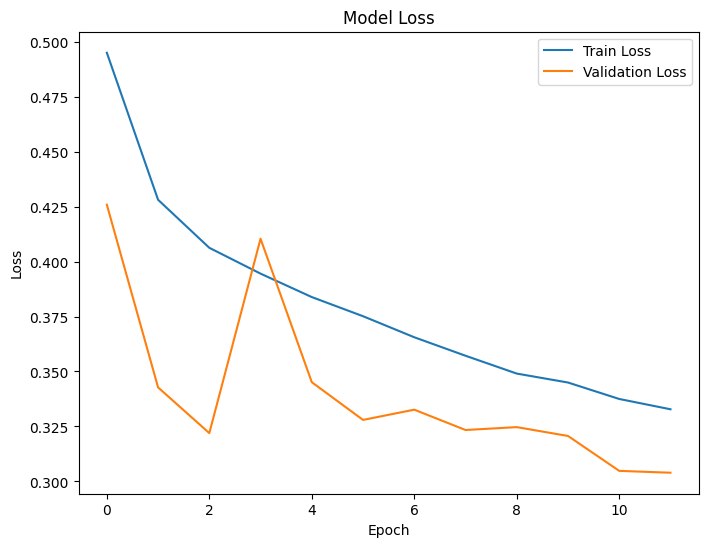

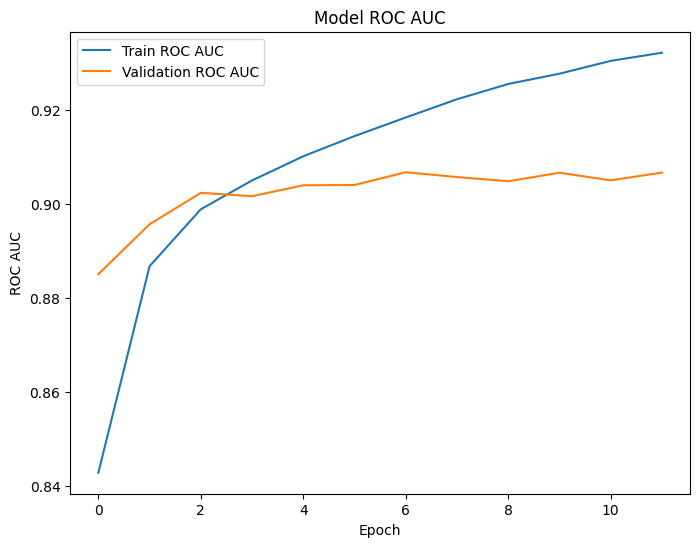

In [15]:
# Plot training & validation loss values
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation ROC AUC values
plt.figure(figsize=(8,6))
plt.plot(history.history['roc_auc'], label='Train ROC AUC')
plt.plot(history.history['val_roc_auc'], label='Validation ROC AUC')
plt.title('Model ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

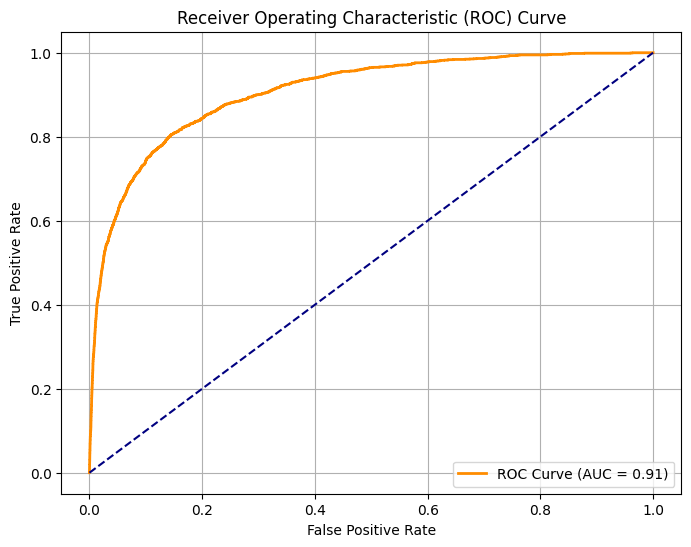

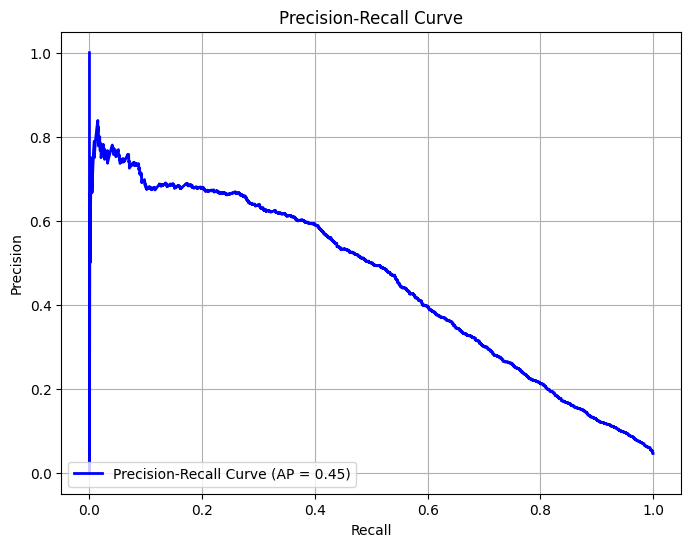

In [16]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_metric:.2f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall Curve (AP = {pr_auc_metric:.2f})', color='blue', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

## Export

In [17]:
# Save the entire model in the TensorFlow SavedModel format
model.save('rnn_model.keras')

In [18]:
# Save max_sequence_length
with open('max_sequence_length.txt', 'w') as f:
    f.write(str(max_sequence_length))
